In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16

# **Loading dataset**

In [2]:
batch_size = 32
img_height = 224
img_width = 224

# from google.colab import drive
# drive.mount('/content/gdrive')

## Mount Google drive

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/Peltarion v1/dataset/train/Image', 
    'dataset/train/Image',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/Peltarion v1/dataset/validation/Image', 
    'dataset/validation/Image',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42
)

Found 1209 files belonging to 8 classes.
Found 303 files belonging to 8 classes.


## Show the data

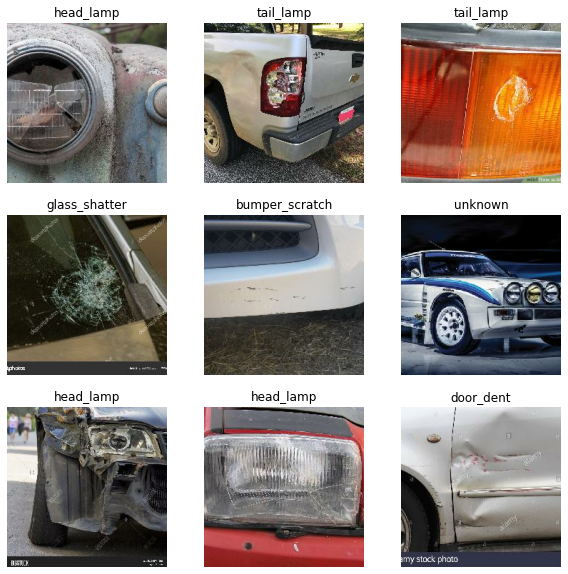

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  titles_str = ['bumper_dent','bumper_scratch','door_dent','door_scratch',
              'glass_shatter','head_lamp','tail_lamp','unknown']
  titles = tf.argmax(labels, axis=1).numpy().tolist()

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(titles_str[titles[i]])
    plt.axis("off")

## Resize, rescale and augment functions

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  # layers.experimental.preprocessing.Rescaling(1./255)
])

## Augment the dataset, preprocess and optimization functions

In [7]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
  # preprocess for VGG16
  ds = ds.map(lambda x, y: (preprocess_input(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

## Running augment, preprocess and optimization functions on dataset

In [8]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True)
val_dataset = prepare(val_dataset)

## Configure dataset for performance (redundant maybe)

In [9]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# **Model definition**

## Model architecture

In [10]:
num_classes = len(titles_str)

# all layers except dense
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# don't retrain the vgg16 conv layers
for layer in model.layers:
	layer.trainable = False


flat1 = Flatten()(model.layers[-1].output)
# dropout1 = Dropout(0.8)(flat1)
class1 = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(0.08))(flat1) # next try 2048
output = Dense(num_classes)(class1)
model = Model(inputs=model.inputs, outputs=output)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 40,414,024
Trainable params: 25,699,336
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile and train

In [14]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20
 2/38 [>.............................] - ETA: 4:37 - loss: 141.6226 - accuracy: 0.1094

KeyboardInterrupt: 

## Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()